In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

# DBScan in 1D

Based off of [cluster-plot-dbscan-py](https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py)

## ToDos

* check that the newly split clusters are 
    * contain enough samples
    * have a total duration longer than the threshold
    * are not embedded within another cluster
* check that newly split _adjacent_ clusters are remergeable
* check that there are no embedded clusters
    * times don't overlap $\checkmark\to$ have function
    * if refined clusters are embedded, check if one cluster is noise
* check the stddev of the refined clusters are smaller

In [3]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

In [4]:
# #############################################################################
%matplotlib inline
import matplotlib.pyplot as plt

## Make the artificial data: 1D1T

**note** "T" here means just the index; later, it could be considered "time"

## Regularize the data

Standardize features by removing the mean and scaling to unit variance

The standard score of a sample `x` is calculated as:

    z = (x - u) / s

where `u` is the mean of the training samples or zero if `with_mean=False`,
and `s` is the standard deviation of the training samples or one if
`with_std=False`.

## DBScan

### Parameters

The basic algorithmic usage
```
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
```

* `eps` : `float`, default=0.5
    * The maximum distance between two samples for one to be considered as in the neighborhood of the other. This is not a maximum bound on the distances of points within a cluster. 
    * This is the most important DBSCAN parameter to choose appropriately for your data set and distance function.

* `min_samples` : `int`, default=5
    * The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.


The main returns
```
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
```

# Sythetic data

In [5]:
import os, sys

sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

#from stay_classification import synthetic_data

from stay_classification.synthetic_data import get_stay_paths, get_journey_path, get_segments

from stay_classification.synthetic_data import get_noise, get_mask

from stay_classification.synthetic_data import get_stay_segs, get_stay, get_seg_info, get_trav

In [47]:
dsec = 1/3600.0

time = np.arange(0,24,dsec)

from stay_classification.synthetic_data import get_stay

stays = [
        get_stay(  0.00,  8.00,-1.00), #home
        get_stay(  8.50, 12.00, 1.10), #work, morning
        get_stay( 12.25, 13.25, 1.60), #lunch
        get_stay( 13.50, 18.00, 1.10), #work, afternoon
        get_stay( 18.50, 20.30,-0.50), #gym
        get_stay( 20.50, 21.50,-2.00), #shopping
        get_stay( 22.00, 24.00, 0.00)  # overnight
    ]

In [52]:
from stay_classification.synthetic_data import get_stay_segs, get_journey_path, get_segments

from stay_classification.synthetic_data import get_mask, get_noise

t_segs, x_segs = get_stay_segs(stays)

raw_journey = get_journey_path(time, get_segments(time, stays, threshold=0.5))

mask = get_mask(time.size, 0.05, False)

mtime = time[mask]


noisy_journey = get_noise(raw_journey[mask])

In [53]:
time.size, mtime.size

(86400, 4320)

In [61]:
import pandas as pd


rand_range = lambda low, high, size: (high-low)*np.random.rand(size) + low

full_times = np.array([])
full_locs = np.array([])

for _ in range(5):
    
    t_segs, x_segs = get_stay_segs(stays)

    time = np.arange(0,24,dsec)

    #raw_stays = get_stay_paths(time, stays)

    raw_journey = get_journey_path(time, get_segments(time, stays, threshold=0.5))

    # Take a sample for speed up 
    rand_rang = rand_range(0.02,0.15,1)[0]

    mask = get_mask(time.size, rand_rang, False)        

    mtime = time[mask]    

    noisy_journey = get_noise(raw_journey[mask])    

    

    # Sample of a sample

    rand_rang = rand_range(0.01,0.16,1)[0]

    #print(rand_rang)

    mask = get_mask(mtime.size, rand_rang, False)                

    full_times = np.hstack([full_times, mtime[mask].transpose()])

    full_locs = np.hstack([full_locs, noisy_journey[mask].transpose()])

df = pd.DataFrame({'t':full_times, 'x':full_locs})

df.sort_values('t', inplace=True)

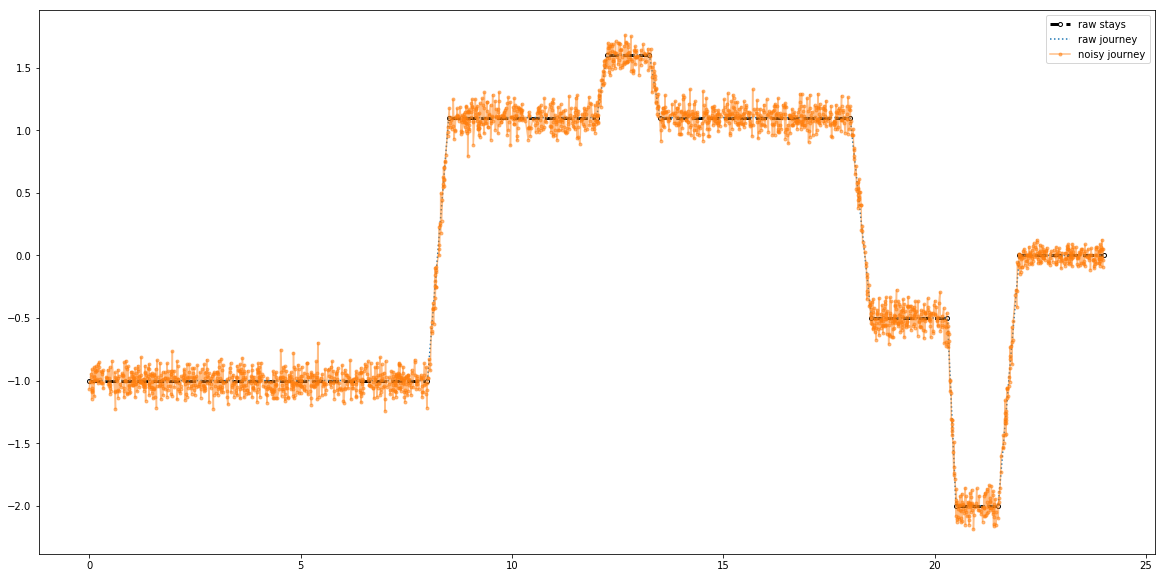

In [62]:
plt.figure(figsize=(20,10))

plt.plot(t_segs, x_segs, 'ko--', linewidth=3.0, markerfacecolor='w', markersize=4.0, markeredgewidth=1.0, label='raw stays')

plt.plot(time, raw_journey, ':', label='raw journey')

plt.plot(df.t, df.x, '.-', label='noisy journey', alpha=0.5)

plt.legend();

In [63]:
xxx = df.t.values.reshape(-1,1)
yyy = df.x.values.reshape(-1,1)
df.shape

(2480, 2)

# Clustering

## Get intial clusters

## Split the clusters which have a temporal gap

In [11]:
import numpy.ma as ma
tdiff = lambda x : np.concatenate([np.array([0.0]), x[1:]-x[:-1]])

In [67]:
from stay_classification.split_clusters import get_split_clusters

time_thresh = (5/60.) # time in hours --> 5 mins is reasonable
eps=0.01
min_samples = 5

db = DBSCAN(eps=eps, min_samples=min_samples).fit(yyy)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

metric_str = 'For %f, nr. clusters: %d, nr noise points: %d' % (eps, n_clusters_, n_noise_)

sil_sco = -1
if np.unique(labels).size>1:
    sil_sco = metrics.silhouette_score(yyy, labels)
    add_str = ", Silhouette Coefficient: %0.3f" % sil_sco
else:
    add_str=''

print(metric_str + add_str)

For 0.010000, nr. clusters: 15, nr noise points: 141, Silhouette Coefficient: 0.497


In [68]:
from stay_classification.plotting_helper import plot_refined, plot_regular

Old labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, -1}
	time break(s) found: for k=0, there are 2 breaks
	time break(s) found: for k=1, there are 3 breaks
	time break(s) found: for k=2, there are 2 breaks
	time break(s) found: for k=3, there are 2 breaks
	time break(s) found: for k=4, there are 8 breaks
	time break(s) found: for k=5, there are 6 breaks
	time break(s) found: for k=6, there are 2 breaks
	time break(s) found: for k=7, there are 4 breaks
	pass on k=8
	time break(s) found: for k=9, there is 1 break
	pass on k=10
	time break(s) found: for k=11, there are 5 breaks
	time break(s) found: for k=12, there are 6 breaks
	time break(s) found: for k=13, there are 2 breaks
	time break(s) found: for k=14, there is 1 break
	but do nothing for k = -1
New labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, -1}


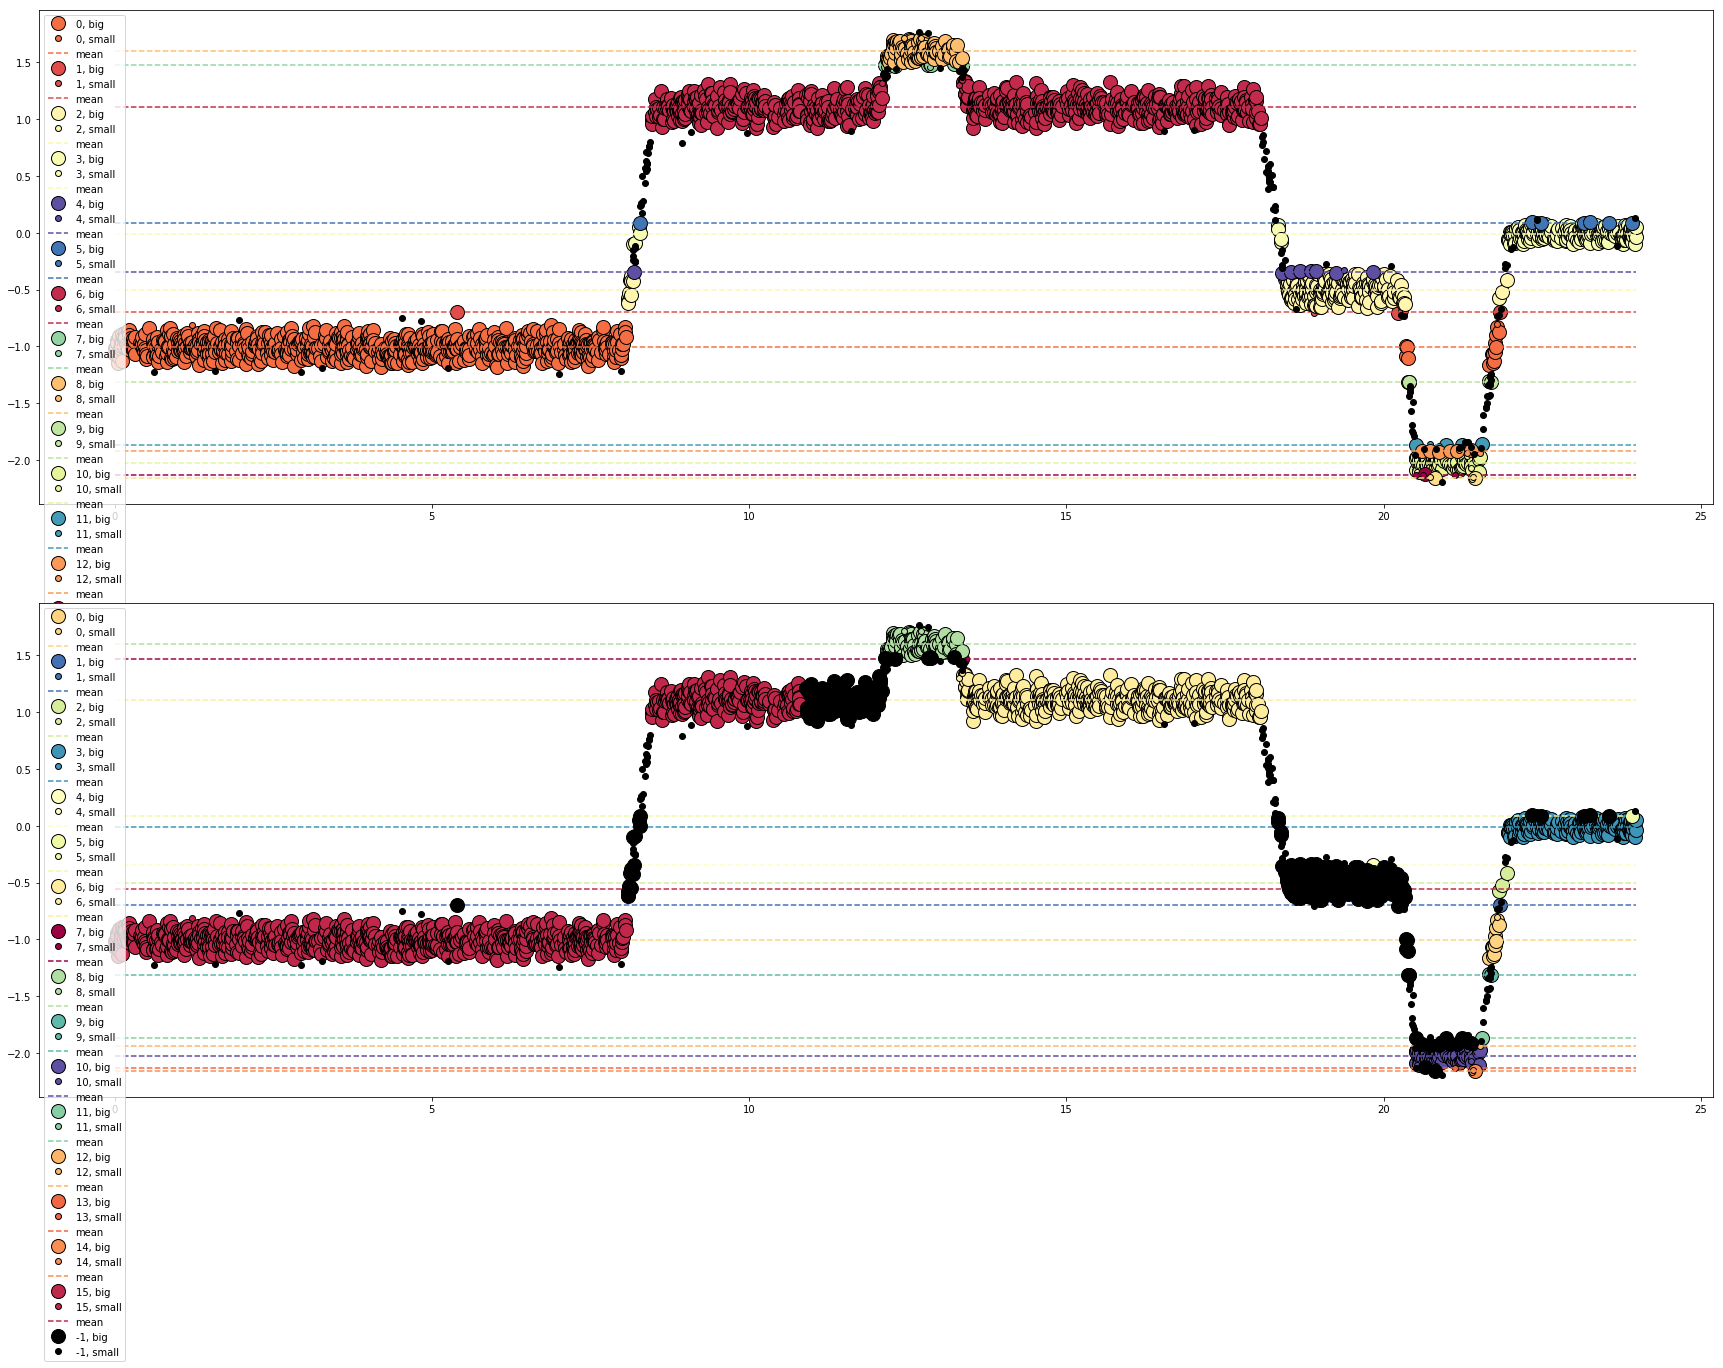

In [69]:
fig, ax = plt.subplots(2,1, figsize=[30,20])


ax[0] = plot_regular(labels, core_samples_mask, xxx, yyy, ax[0])
ax[0].legend()

labels_ = get_split_clusters(labels, time_thresh, xxx, yyy)

ax[1] = plot_regular(labels_, core_samples_mask, xxx, yyy, ax[1])
ax[1].legend()

In [20]:
tdiff = lambda x : np.concatenate([np.array([0.0]), x[1:]-x[:-1]])
td = tdiff(xxx.reshape(xxx.size))
td_breaks = (td > time_thresh)

In [33]:
print(xxx[20:25].reshape(1,-1)[0])
print(td[20:25])
print(td_breaks[20:25])

[0.4075     0.43166667 0.52416667 0.56388889 0.57583333]
[0.03111111 0.02416667 0.0925     0.03972222 0.01194444]
[False False  True False False]


## Refinement

In [14]:
import random


For coarse cluster=0, coarse std = 0.123108,
	eps: 0.040000, nr. clusters: 0, nr noise points: 5
	fine cluster=-1, fine std = 0.12310845038499124

For coarse cluster=1, coarse std = 0.032038,
	eps: 0.040000, nr. clusters: 1, nr noise points: 1, Silhouette Coefficient: 0.339
	fine cluster=0, fine std = 0.027968278850433823
	fine cluster=-1, fine std = 0.0

For coarse cluster=2, coarse std = 0.026381,
	eps: 0.040000, nr. clusters: 0, nr noise points: 4
	fine cluster=-1, fine std = 0.026380976531341253

For coarse cluster=3, coarse std = 0.000000,
	eps: 0.040000, nr. clusters: 0, nr noise points: 1
	fine cluster=-1, fine std = 0.0

For coarse cluster=4, coarse std = 0.097105,
	eps: 0.040000, nr. clusters: 0, nr noise points: 7
	fine cluster=-1, fine std = 0.09710506337154233

For coarse cluster=5, coarse std = 0.011271,
	eps: 0.040000, nr. clusters: 0, nr noise points: 3
	fine cluster=-1, fine std = 0.011270961067339467

For coarse cluster=6, coarse std = 0.082381,
	eps: 0.040000, nr. cl

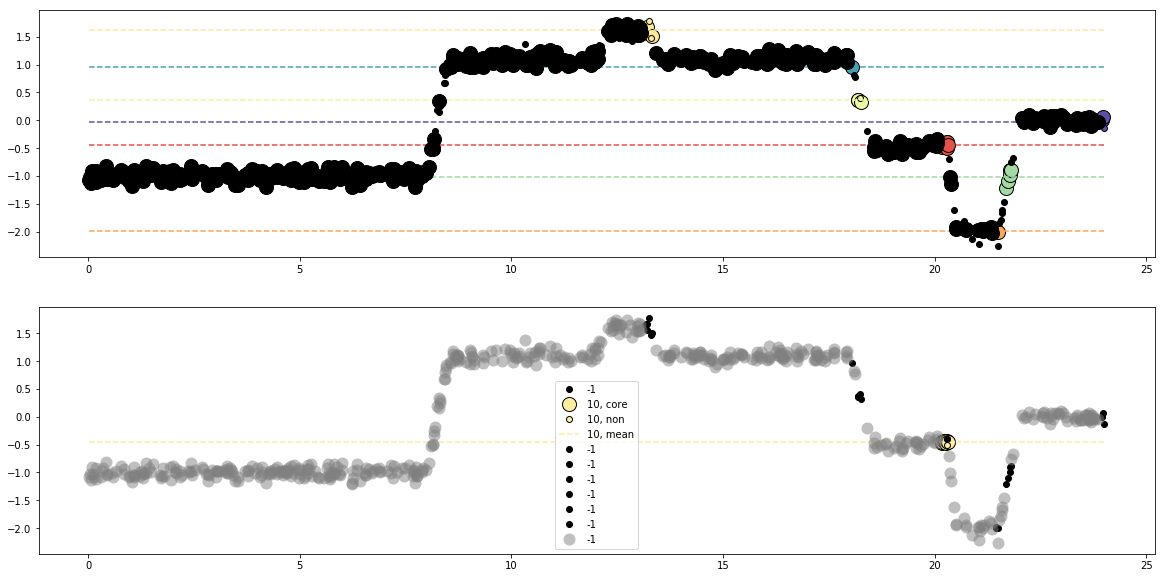

In [15]:
eps=0.04
min_samples = 5

coarse_unique_labels = set(labels)

colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 10)]
random.shuffle(colors)

fig, ax = plt.subplots(2,1, figsize=[20,10])

ax = ax.reshape(2)

ax[0] = plot_regular(labels, core_samples_mask, xxx, yyy, ax[0])

color_n = 0 
# iterate through the new labeled clusters
# redo dbscan for each cluster
# remove the outliers 
for coarse_label in coarse_unique_labels:

    if coarse_label == -1:
        
        coarse_cluster_mask = (labels == coarse_label)

        x = xxx[coarse_cluster_mask]
        y = yyy[coarse_cluster_mask]  

        ax[1].plot(x,y, 'o', markersize=12, 
                markerfacecolor='grey', markeredgecolor='grey', markeredgewidth=0,
                alpha=0.5, label='{}'.format(-1))
     
    else:
        # Mask the new events according the the updated labels
        coarse_cluster_mask = (labels == coarse_label)
        xx_coarse = xxx[coarse_cluster_mask]
        yy_coarse = yyy[coarse_cluster_mask]   
        coarse_std = np.std(yy_coarse)
        
        #print(xx_coarse.size, yy_coarse.size)
        
        # don't need to do this? or check this?
        #newnew_X = StandardScaler().fit_transform(yy_coarse)
        newnew_X = yy_coarse
        #print(newnew_X.size)    

        # Rerun DBScan with a smaller eps-param?
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(yy_coarse)
        fine_core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        fine_core_samples_mask[db.core_sample_indices_] = True
        fine_cluster_labels = db.labels_

        fine_n_clusters_ = len(set(fine_cluster_labels)) - (1 if -1 in fine_cluster_labels else 0)
        fine_n_noise_ = list(fine_cluster_labels).count(-1)

        metric_str = '\nFor coarse cluster=%d, coarse std = %f,\n\teps: %f, nr. clusters: %d, nr noise points: %d' \
            % (coarse_label, coarse_std, eps, fine_n_clusters_, fine_n_noise_)

        sil_sco = -1
        if np.unique(fine_cluster_labels).size>1:
            sil_sco = metrics.silhouette_score(yy_coarse, fine_cluster_labels)
            add_str = ", Silhouette Coefficient: %0.3f" % sil_sco
        else:
            add_str=''

        print(metric_str + add_str)

        fine_unique_labels = set(fine_cluster_labels)

        # Loop over the new refined clusters to exclude the noise
        # Black removed and is used for noise instead.
        col = colors[color_n]

        for fine_label in fine_unique_labels:

            if fine_label==-1:
                
                col = [0, 0, 0, 1]                
                fine_cluster_mask = (fine_cluster_labels == -1)
                x = xx_coarse[fine_cluster_mask]
                y = yy_coarse[fine_cluster_mask]  

                ax[1].plot(x,y, 'o', markerfacecolor=tuple(col),
                             markeredgecolor='k', markersize=6, label=f'{fine_label}')
                    
                fine_std = np.std(y)
                
            else:

                fine_cluster_mask = (fine_cluster_labels == fine_label)

                x = xx_coarse[fine_cluster_mask & fine_core_samples_mask]
                y = yy_coarse[fine_cluster_mask & fine_core_samples_mask]    

                ax[1].plot(x,y, 'o', markerfacecolor=tuple(col),
                         markeredgecolor='k', markersize=14, label='{}{}, core'.format(coarse_label, fine_label))

                x = xx_coarse[fine_cluster_mask & ~fine_core_samples_mask]
                y = yy_coarse[fine_cluster_mask & ~fine_core_samples_mask]  

                ax[1].plot(x,y, 'o', markerfacecolor=tuple(col),
                         markeredgecolor='k', markersize=6, label='{}{}, non'.format(coarse_label, fine_label))

                y_mean = yy_coarse[fine_cluster_mask].mean()
                ax[1].plot([xxx[0],xxx[-1]],[y_mean, y_mean], '--', color=tuple(col), label='{}{}, mean'.format(coarse_label, fine_label))    

                fine_std = np.std(yy_coarse[fine_cluster_mask])
        
            print(f"\tfine cluster={fine_label}, fine std = {fine_std}")
        
        color_n += 1
    plt.legend()